In [126]:
# libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plot
import tensorflow as tf
from scipy.linalg import svd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler


In [127]:
# Read and preprocess the dataf
energy_data = pd.read_csv("NI_hourly.csv")
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])
energy_data['hour'] = energy_data['Datetime'].dt.hour
energy_data['date'] = energy_data['Datetime'].dt.date

# Sort chronologically by Datetime
energy_data = energy_data.sort_values('Datetime')
energy_data.set_index('Datetime',inplace=True)

In [82]:
# initial print check to see if everything is okay
print(energy_data)

                       NI_MW  hour        date
Datetime                                      
2004-05-01 01:00:00   9198.0     1  2004-05-01
2004-05-01 02:00:00   8570.0     2  2004-05-01
2004-05-01 03:00:00   8183.0     3  2004-05-01
2004-05-01 04:00:00   7917.0     4  2004-05-01
2004-05-01 05:00:00   7828.0     5  2004-05-01
...                      ...   ...         ...
2010-12-31 20:00:00  11585.0    20  2010-12-31
2010-12-31 21:00:00  11243.0    21  2010-12-31
2010-12-31 22:00:00  10825.0    22  2010-12-31
2010-12-31 23:00:00  10511.0    23  2010-12-31
2011-01-01 00:00:00  10042.0     0  2011-01-01

[58450 rows x 3 columns]


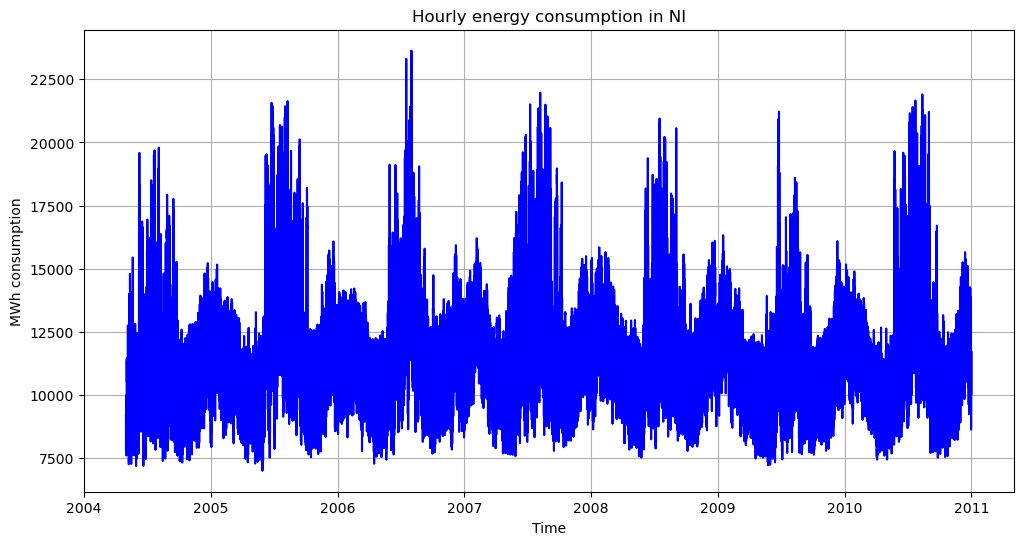

In [83]:

# Plot hourly consumption
plot.figure(figsize=(12, 6))
plot.plot(energy_data['NI_MW'], color='blue')
plot.xlabel('Time')
plot.ylabel('MWh consumption')
plot.title('Hourly energy consumption in NI')
plot.grid()
plot.show()

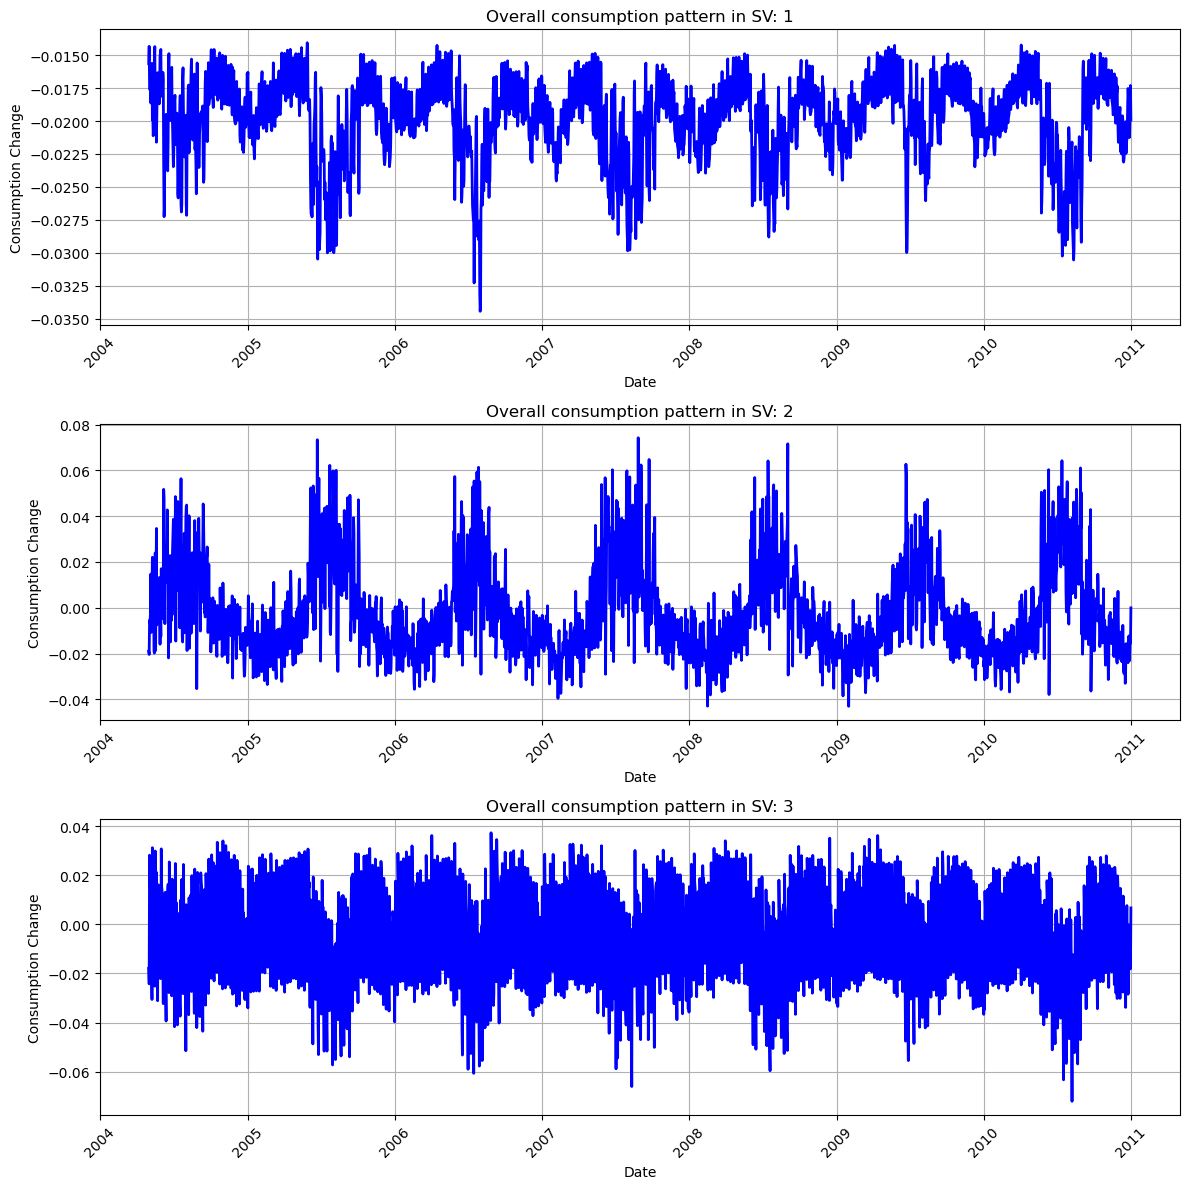

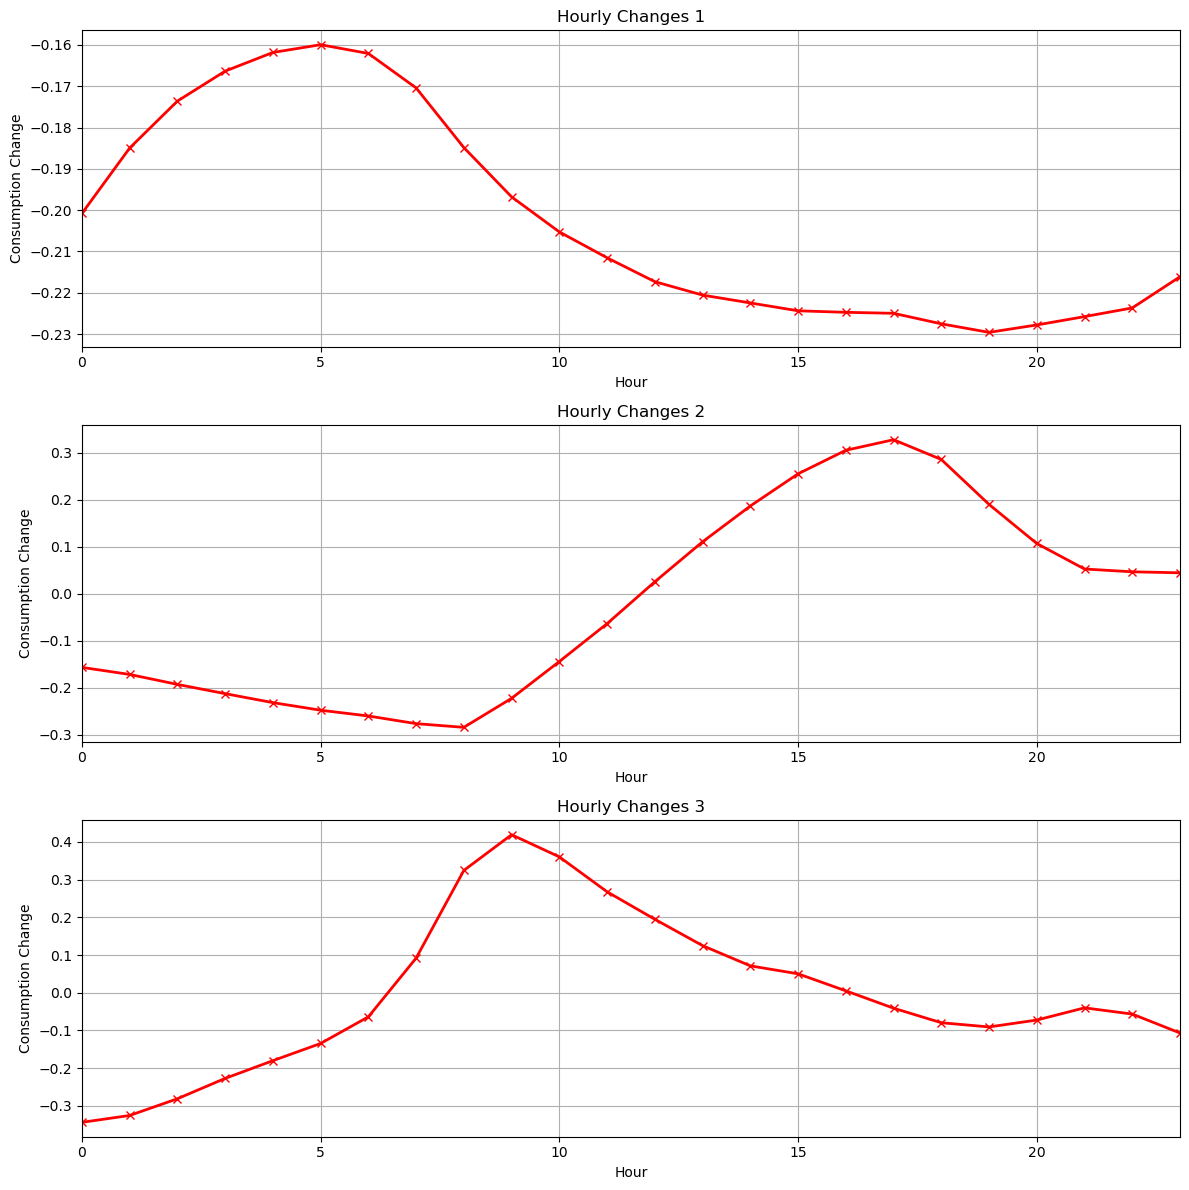

In [84]:
# Create pivot table for SVD analysis
pivoted_data = energy_data.pivot_table(
    values='NI_MW', 
    index='date',
    columns='hour',
    aggfunc='mean'
)
pivoted_data = pivoted_data.fillna(pivoted_data.mean())
matrix = pivoted_data.values

# Perform SVD
U, S, Vt = svd(matrix, full_matrices=False)
V = Vt.T

# Plot overall consumption patterns from SVD
plot.figure(figsize=(12, 12))
for i in range(3):
    plot.subplot(3, 1, i+1)
    plot.plot(pivoted_data.index, U[:, i], linewidth=2, color='blue')
    plot.title(f'Overall consumption pattern in SV: {i+1}')
    plot.xlabel('Date')
    plot.ylabel('Consumption Change')
    plot.grid(True)
    plot.xticks(rotation=45)
plot.tight_layout()
plot.show()

# Plot hourly patterns from SVD
plot.figure(figsize=(12, 12))
for i in range(3):
    plot.subplot(3, 1, i+1)
    plot.plot(range(24), V[:, i], 'rx-', linewidth=2)
    plot.title(f'Hourly Changes {i+1}')
    plot.xlabel('Hour')
    plot.ylabel('Consumption Change')
    plot.xlim(0, 23)
    plot.grid(True)
plot.tight_layout()
plot.show()

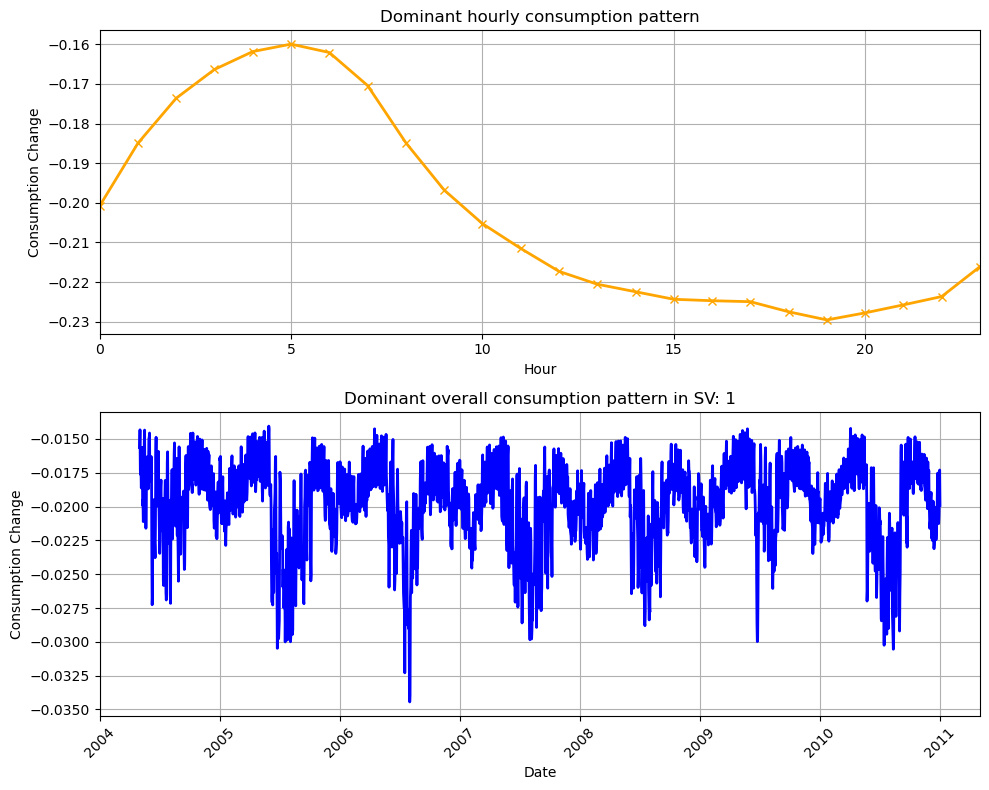

In [85]:
# Create figure with 2 subplots arranged vertically
fig, (ax1, ax2) = plot.subplots(2, 1, figsize=(10, 8))

# First subplot
hours = np.arange(24)  # 0:23
ax1.plot(hours, V[:,0], 'orange', marker='x', linewidth=2)
ax1.set_title('Dominant hourly consumption pattern')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Consumption Change')
ax1.set_xlim([0, 23])
ax1.grid(True)

# Second subplot
ax2.plot(pivoted_data.index, U[:, 0], linewidth=2, color='blue')  # Fixed this line
ax2.set_title(f'Dominant overall consumption pattern in SV: {1}')
ax2.set_xlabel('Date')
ax2.set_ylabel('Consumption Change')
plot.setp(ax2.xaxis.get_ticklabels(), rotation=45)
ax2.grid(True)

# Adjust layout to prevent overlap
plot.tight_layout()

# Display the plot
plot.show()

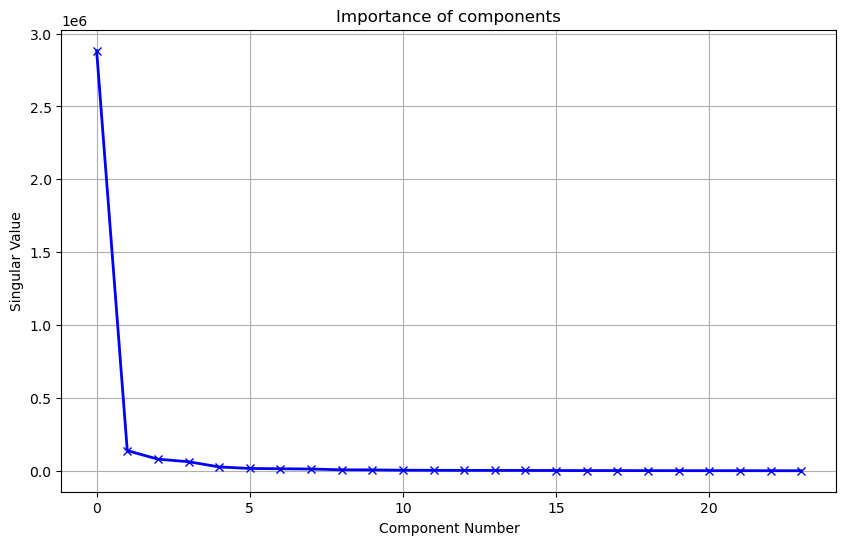

In [130]:
# Plot singular values

plot.figure(figsize=(10, 6))
plot.plot(S, 'bx-', linewidth=2)
plot.xlabel('Component Number')
plot.ylabel('Singular Value')
plot.title('Importance of components')
plot.grid(True)
plot.show()

In [131]:
# Index reset here - Just for Erics section with the decomp
energy_data = energy_data.reset_index()


In [132]:
print(energy_data['Datetime'])

0       2004-05-01 01:00:00
1       2004-05-01 02:00:00
2       2004-05-01 03:00:00
3       2004-05-01 04:00:00
4       2004-05-01 05:00:00
                ...        
58445   2010-12-31 20:00:00
58446   2010-12-31 21:00:00
58447   2010-12-31 22:00:00
58448   2010-12-31 23:00:00
58449   2011-01-01 00:00:00
Name: Datetime, Length: 58450, dtype: datetime64[ns]


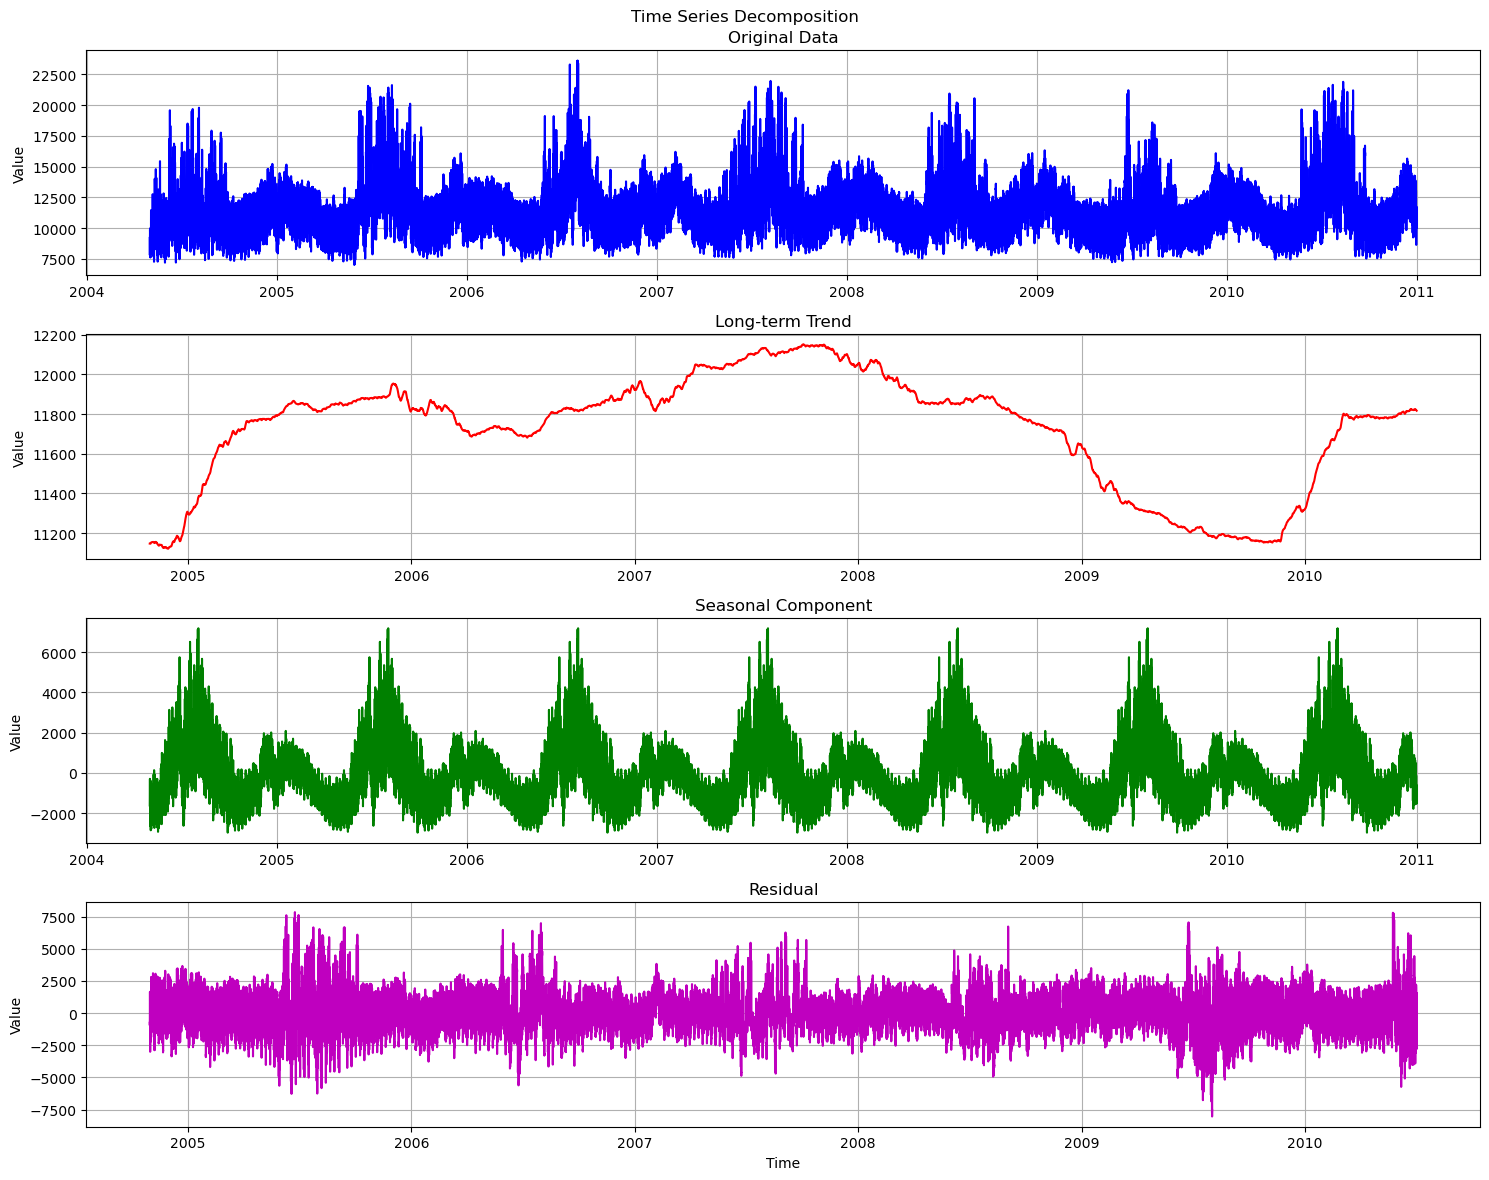

In [133]:
# Time series decomposition
ts_data = pd.Series(
    energy_data['NI_MW'].values,
    index=pd.DatetimeIndex(energy_data['Datetime']),
    name='NI_MW'
)
ts_data = ts_data.sort_index()

# Perform decomposition

# Yearly seasonality
decomposition = seasonal_decompose(
    ts_data,
    model="additive",
    period=24*365, # yearly seasonality
    extrapolate_trend=0
)


# Plot decomposition results
fig, (ax1, ax2, ax3, ax4) = plot.subplots(4, 1, figsize=(15, 12))

# Original Data
ax1.plot(ts_data.index, ts_data.values, 'b-', linewidth=1.5)
ax1.set_title('Original Data')
ax1.grid(True)
ax1.set_ylabel('Value')

# Trend
ax2.plot(ts_data.index, decomposition.trend, 'r-', linewidth=1.5)
ax2.set_title('Long-term Trend')
ax2.grid(True)
ax2.set_ylabel('Value')

# Seasonal
ax3.plot(ts_data.index, decomposition.seasonal, 'g-', linewidth=1.5)
ax3.set_title('Seasonal Component')
ax3.grid(True)
ax3.set_ylabel('Value')

# Residual
ax4.plot(ts_data.index, decomposition.resid, 'm-', linewidth=1.5)
ax4.set_title('Residual')
ax4.grid(True)
ax4.set_xlabel('Time')
ax4.set_ylabel('Value')


# Adjust layout for decomposition plot
plot.suptitle('Time Series Decomposition')
plot.tight_layout()
plot.show()

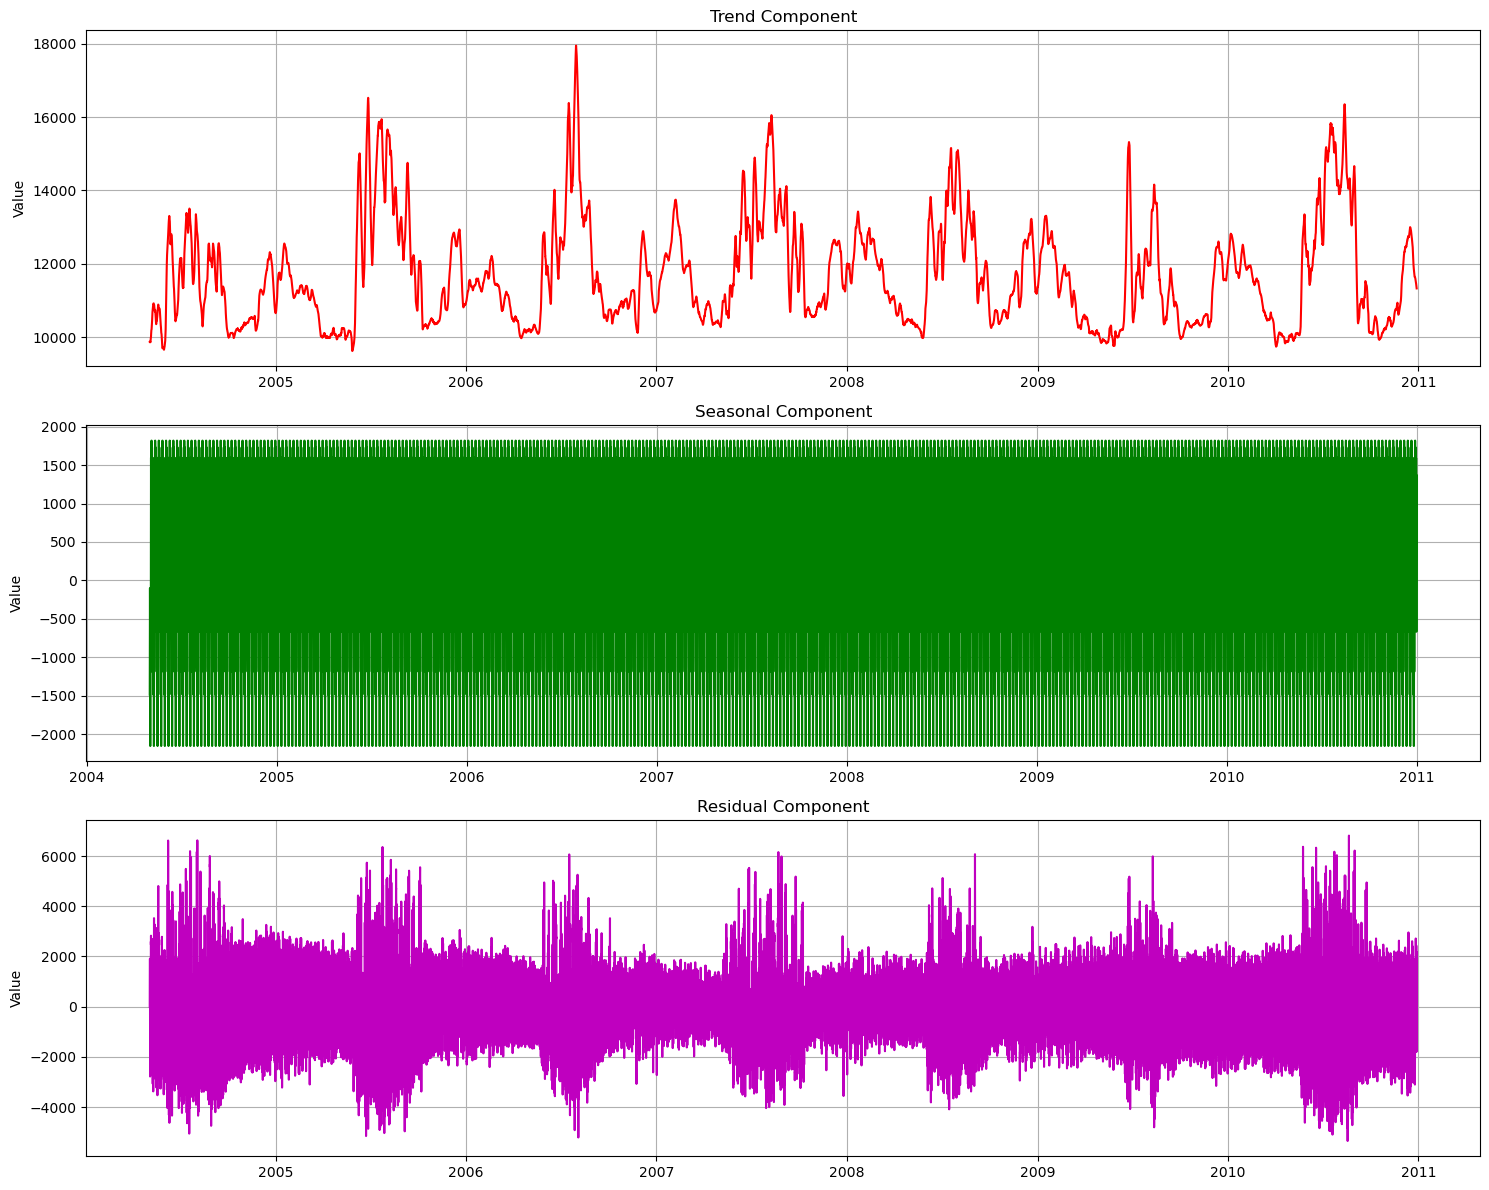

In [134]:
# Weekly decomposition

# Weekly seasonality 168 hours
weekly_decomposition = seasonal_decompose(
    ts_data, model="additive", period=24*7, extrapolate_trend=0
)
fig, (ax5, ax6, ax7) = plot.subplots(3, 1, figsize=(15, 12))

ax5.plot(weekly_decomposition.trend, 'r')
ax5.set_title('Trend Component')
ax5.set_ylabel('Value')
ax5.grid()

ax6.plot(weekly_decomposition.seasonal, 'g')
ax6.set_title('Seasonal Component')
ax6.set_ylabel('Value')
ax6.grid()

ax7.plot(weekly_decomposition.resid, 'm')
ax7.set_title('Residual Component')
ax7.set_ylabel('Value')
ax7.grid()

plot.tight_layout()
plot.show()

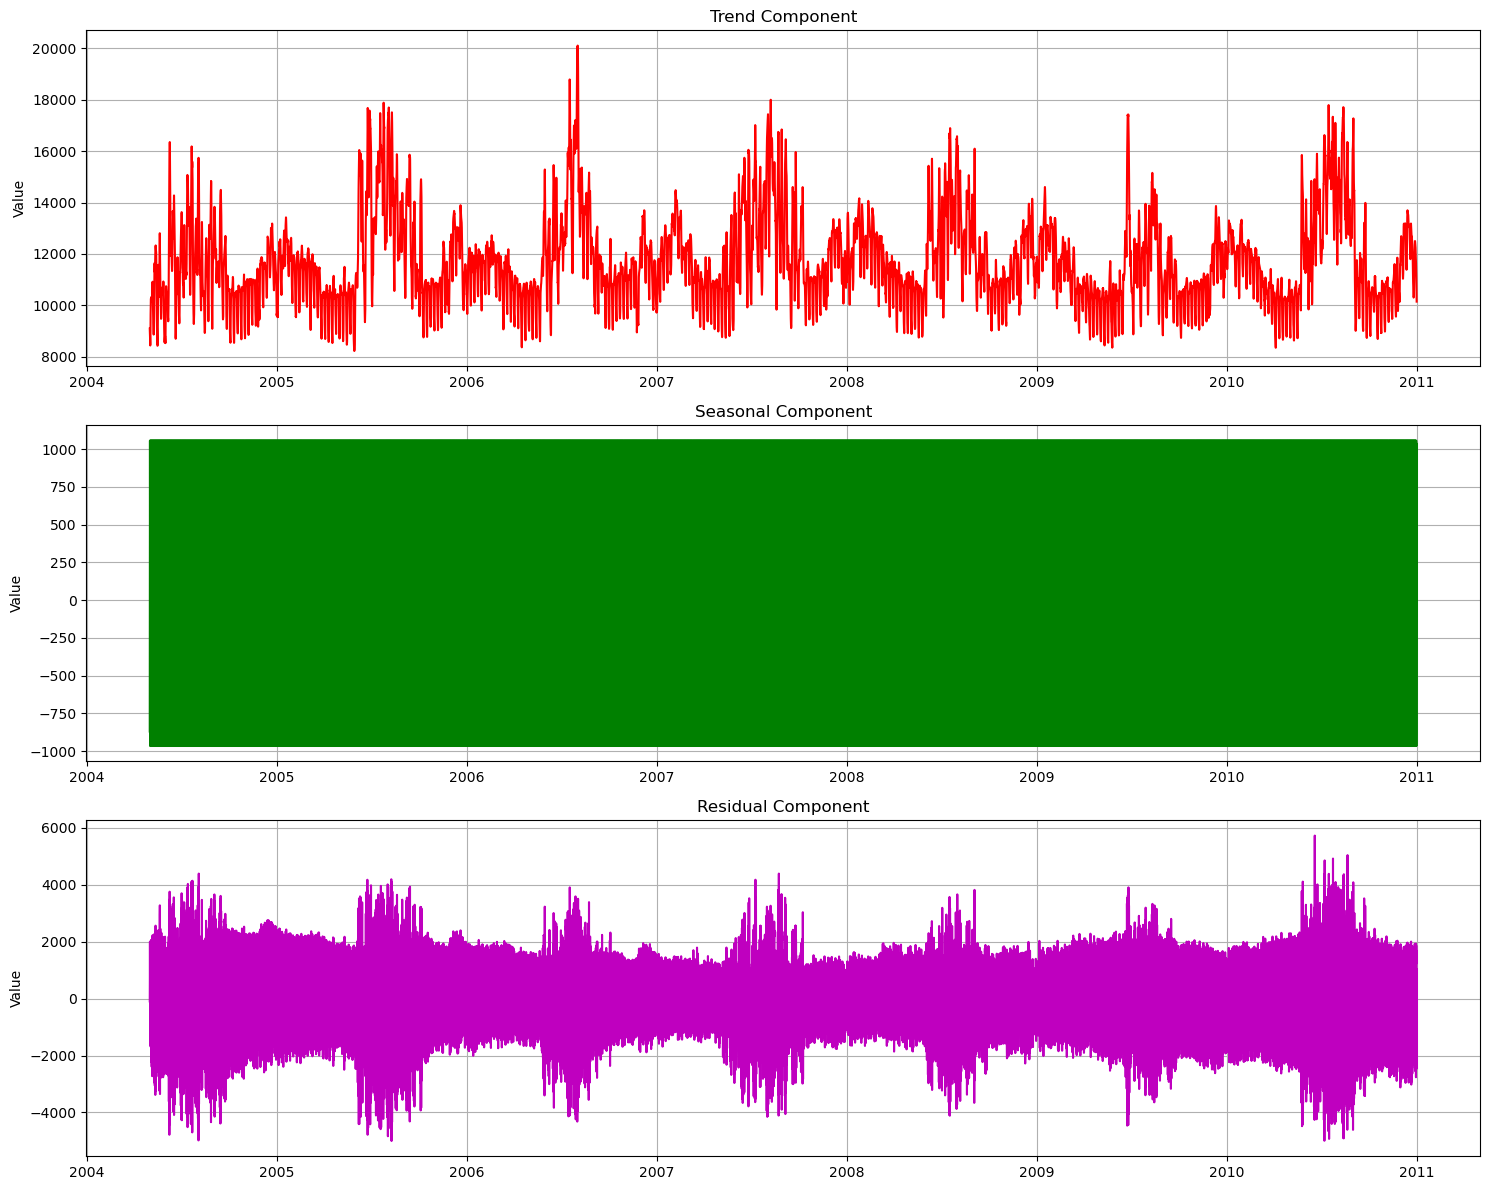

In [135]:
# Daily decomposition
# Daily seasonality 24 hours
daily_decomposition = seasonal_decompose(
    ts_data, model="additive", period=24, extrapolate_trend=0
)

fig, (ax8, ax9, ax10) = plot.subplots(3, 1, figsize=(15, 12))

ax8.plot(daily_decomposition.trend, 'r')
ax8.set_title('Trend Component')
ax8.set_ylabel('Value')
ax8.grid()

ax9.plot(daily_decomposition.seasonal, 'g')
ax9.set_title('Seasonal Component')
ax9.set_ylabel('Value')
ax9.grid()

ax10.plot(daily_decomposition.resid, 'm')
ax10.set_title('Residual Component')
ax10.set_ylabel('Value')
ax10.grid()

plot.tight_layout()
plot.show()

<Figure size 1000x600 with 0 Axes>

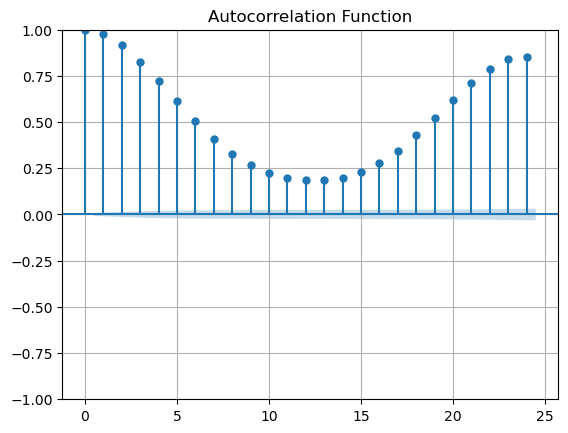

In [136]:
# Plot autocorrelation
plot.figure(figsize=(10, 6))
plot_acf(energy_data['NI_MW'], lags=24)
plot.grid(True)
plot.title('Autocorrelation Function')
plot.show()

In [137]:
# Index swapping 
energy_data.index = pd.to_datetime(energy_data.index)
print(energy_data['NI_MW'])

1970-01-01 00:00:00.000000000     9198.0
1970-01-01 00:00:00.000000001     8570.0
1970-01-01 00:00:00.000000002     8183.0
1970-01-01 00:00:00.000000003     7917.0
1970-01-01 00:00:00.000000004     7828.0
                                  ...   
1970-01-01 00:00:00.000058445    11585.0
1970-01-01 00:00:00.000058446    11243.0
1970-01-01 00:00:00.000058447    10825.0
1970-01-01 00:00:00.000058448    10511.0
1970-01-01 00:00:00.000058449    10042.0
Name: NI_MW, Length: 58450, dtype: float64


In [138]:
# Params 

# Prepare sliding window dataset (X, Y)
window_size = 24 * 7
# Forecasting one hour
forecast_horizon = 1
# Number of timesteps moved forward each iteration
stride = 168 

In [147]:
# Init scaler -- Use minmax scaler suggested by lit review
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape decomp vals for LSTM
residual = daily_decomposition.resid.dropna().values.reshape(-1, 1)
trend = daily_decomposition.trend.dropna().values.reshape(-1, 1)
seasonal = daily_decomposition.seasonal.dropna().values.reshape(-1, 1)

# Scale decomp values for LTSM
residual_scaled = scaler.fit_transform(residual)
trend_scaled = scaler.fit_transform(trend)
seasonal_scaled = scaler.fit_transform(seasonal)

# Make sure X and Y values align - predictions done on resixs
X_residual = residual_scaled[:-forecast_horizon]  
Y_residual = residual_scaled[forecast_horizon:]


In [148]:
# Personal unnecessary garbage -- J
print(len(residual) - window_size - forecast_horizon, stride)
print(49521/stride)

58257 168
294.76785714285717


In [149]:
# Variable storage
all_predictions = []
all_true_values = []
timestamps = []  

# Hyperparams
epochs = 3
network_size = 256

# Prepare model once before the loop
model = Sequential([
    LSTM(network_size, activation='relu', input_shape=(1, 1)),
    Dense(1, activation='relu')
])

#  Compile model with metrics etc...
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'root_mean_squared_error'])

for start in range(0, len(residual) - window_size - forecast_horizon, stride):
    train_start = start
    train_end = start + window_size
    val_start = train_end
    val_end = val_start + forecast_horizon

    # Split residual into rolling window training and validation sets
    X_train = X_residual[train_start:train_end].reshape(-1, 1, 1)  # Add time and feature dimensions
    Y_train = Y_residual[train_start:train_end]
    X_val = X_residual[val_start:val_end].reshape(-1, 1, 1)
    Y_val = Y_residual[val_start:val_end]

    # Model training
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, verbose=1)

    # Evaluate the model on validation set - exit criteria could be set here
    predictions = model.predict(X_val, batch_size=64)
    
    # Store predictions and actual values
    all_predictions.extend(predictions.flatten())  # Flatten to avoid any dimension issues
    all_true_values.extend(Y_val.flatten())  # Flatten the true values similarly

    # Store the corresponding timestamps for plotting
    timestamps.extend(energy_data['Datetime'][val_start:val_end].values)

Epoch 1/3


/home/joonas/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2291 - mae: 0.4645 - root_mean_squared_error: 0.4783 - val_loss: 0.1874 - val_mae: 0.4329 - val_root_mean_squared_error: 0.4329
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1937 - mae: 0.4249 - root_mean_squared_error: 0.4401 - val_loss: 0.1633 - val_mae: 0.4041 - val_root_mean_squared_error: 0.4041
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1675 - mae: 0.3924 - root_mean_squared_error: 0.4093 - val_loss: 0.1412 - val_mae: 0.3758 - val_root_mean_squared_error: 0.3758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1541 - mae: 0.3653 - root_mean_squared_error: 0.3925 - val_loss: 0.1170 - val_mae: 0.3420 - val_root_mean_squared_error: 0.3420
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1337 - mae: 0.3376 - root_mean_squared_error: 0.3656 - val_loss: 0.0959 - val_mae: 0.3097 - val_root_mean_squared_error: 0.3097
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

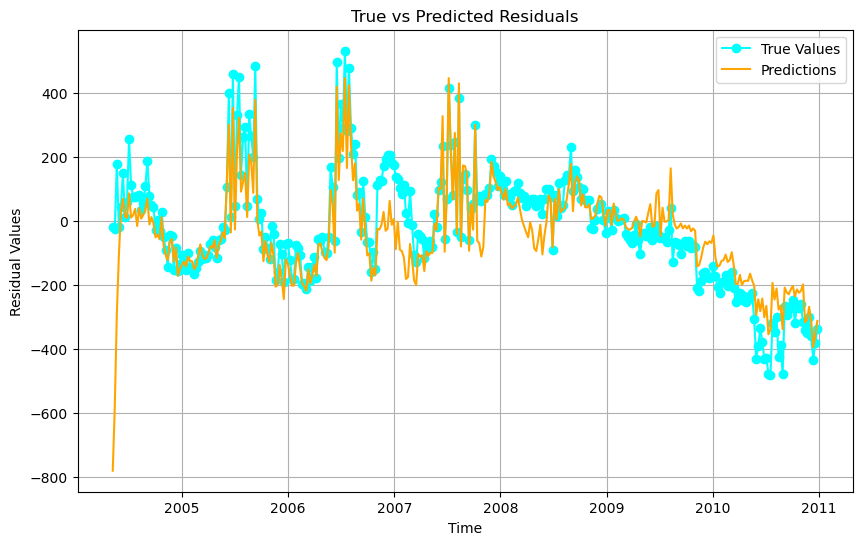

In [152]:
all_predictions_original = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()
all_true_values_original = scaler.inverse_transform(np.array(all_true_values).reshape(-1, 1)).flatten()

# Redo seasonal and trend values
seasonal_values = seasonal[len(seasonal) - len(all_predictions_original):].flatten()
trend_values = trend[len(trend) - len(all_predictions_original):].flatten()

# Reseasonalize predictions
reseasonalized_predictions = all_predictions_original + seasonal_values + trend_values

plot.figure(figsize=(10, 6))
plot.plot(timestamps, all_true_values_original, label='True Values', color='cyan', linestyle='-', marker='o')
plot.plot(timestamps, all_predictions_original, label='Predictions', color='orange', linestyle='-')

# Add labels and title

plot.xlabel('Time')
plot.ylabel('Residual Values')
plot.title('True vs Predicted Residuals')
plot.legend()
plot.grid()
plot.show()

[ 9198.  8570.  8183. ... 10825. 10511. 10042.]


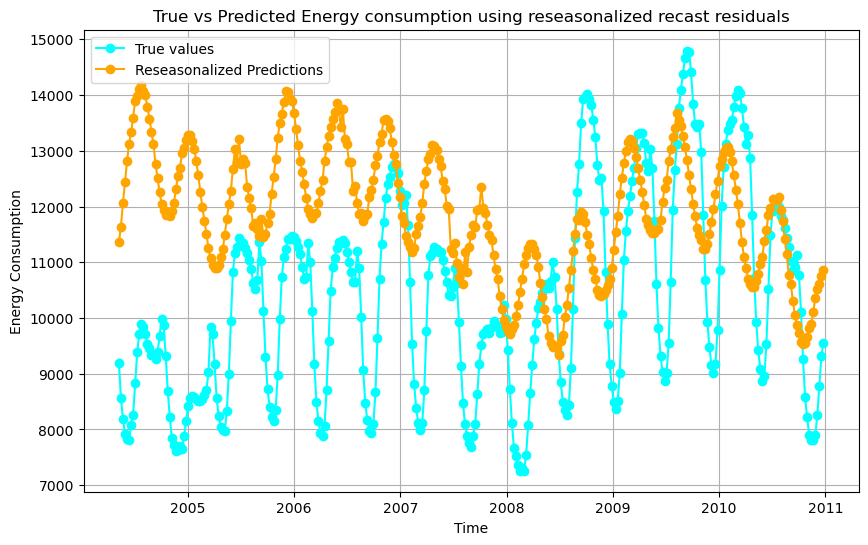

In [153]:
#energy_data['NI_MW_unscaled'] = scaler.inverse_transform(energy_data[['NI_MW']])
original_consumption_data = energy_data['NI_MW'].values
print(original_consumption_data)
plot.figure(figsize=(10, 6))
plot.plot(timestamps, original_consumption_data[:len(timestamps)], label='True values', color='cyan', linestyle='-', marker='o')
plot.plot(timestamps, reseasonalized_predictions, label='Reseasonalized Predictions', color='orange', marker='o')
plot.xlabel('Time')
plot.ylabel('Energy Consumption')
plot.title('True vs Predicted Energy consumption using reseasonalized recast residuals')
plot.legend()
plot.grid()
plot.show()